In [45]:
from __future__ import print_function, division # Python 3 printing and division

import pandas as pd
import numpy as np
import seaborn as sns
import os, shutil, glob

# from sklearn.utils.extmath import cartesian
import matplotlib.pyplot as plt
from SALib.sample import saltelli, latin
import pystran

import pystran
%matplotlib inline

In [2]:
def reshape_files(case_dir,case_name,sim_type,num_scenarios):
    """
    Takes in WEST output files (Steady State.out.txt or Dynamic.out.txt) in a directory (case_dir),
    reads them and arranges them per output variable (instead of per scenario) in a dictionary
    """
    #Initialise everything by reading first file 
    file_name = '%04d'%0 + '_' + case_name + '.' + sim_type + '.' + 'Simul.out.txt'
    output = pd.read_csv(os.path.join(case_dir, file_name), sep='\t')
    result_dict = {k: pd.DataFrame() for k in output.columns}
    result_units = {tag: unit for tag,unit in zip(output.columns,output.loc[0])}
    
    for var_name in result_dict.keys():
        result_dict[var_name]['scen'+'%d'%0] = output[var_name][1:].astype(float)
    
    #Loop over the rest of the files, once per file and once per output variable
    for i in range(1,num_scenarios):
        file_name = '%04d'%i + '_' + case_name + '.' + sim_type + '.' + 'Simul.out.txt'
        output = pd.read_csv(os.path.join(case_dir, file_name), sep='\t')
        for var_name in result_dict.keys():
            previous_data = result_dict[var_name]
            new_data = pd.DataFrame({'scen'+'%d'%i : output[var_name][1:].astype(float)})
            result_dict[var_name] = pd.concat([previous_data,new_data],axis=1)
    
    return result_dict, result_units
    

def run_GSA(scenario, case_dir, case_name, save_dir, experiment_type, timeout_duration):
    scen_id = scenario[0]
    parameter_dict = scenario[1]
    #parameter_dict=dict(zip(parsets2run.columns.values,values))

    scen = py2WEST.WestWrapper(case_dir, case_name, save_dir, scen_id, parameter_dict,
                               experiment_type=experiment_type, timeout=timeout_duration)
    scen.run_west()
    
    #include reshape files function here, so this function is also executed on cluster
    return [scen_id, scen.succes]

# Sample preparation

## SALib param preparation

In [209]:
problem = {
  'num_vars': 13,
  'names': ['K_O_A1Lysis', 'K_O_A2Lysis', 'b_A1',
           'b_A2', 'Y_A1', 'Y_A2',
           'K_FA_AOBden', 'K_FNA_AOBden', 'K_IO_AOBden',
           'K_SNO_AOBden', 'K_SO_AOBden', 'n1_AOB', 'n2_AOB'],
  'bounds': [[0.06, 1.74], [0.151, 0.739], [0.0028, 0.3052],
            [0.0028, 0.3052], [0.14, 0.25], [0.042,  0.258],
            [0.0009, 1.1], [0.0000005, 0.003], [0.01, 11],
            [0.08, 4.3], [0.01, 13.2], [0.025, 0.685], [0.025, 0.685]]
}

# Generate samples
param_values = latin.sample(problem, 10000)#, calc_second_order=True)
columns=problem['names'] 

In [222]:
param_values.shape

(10000, 13)

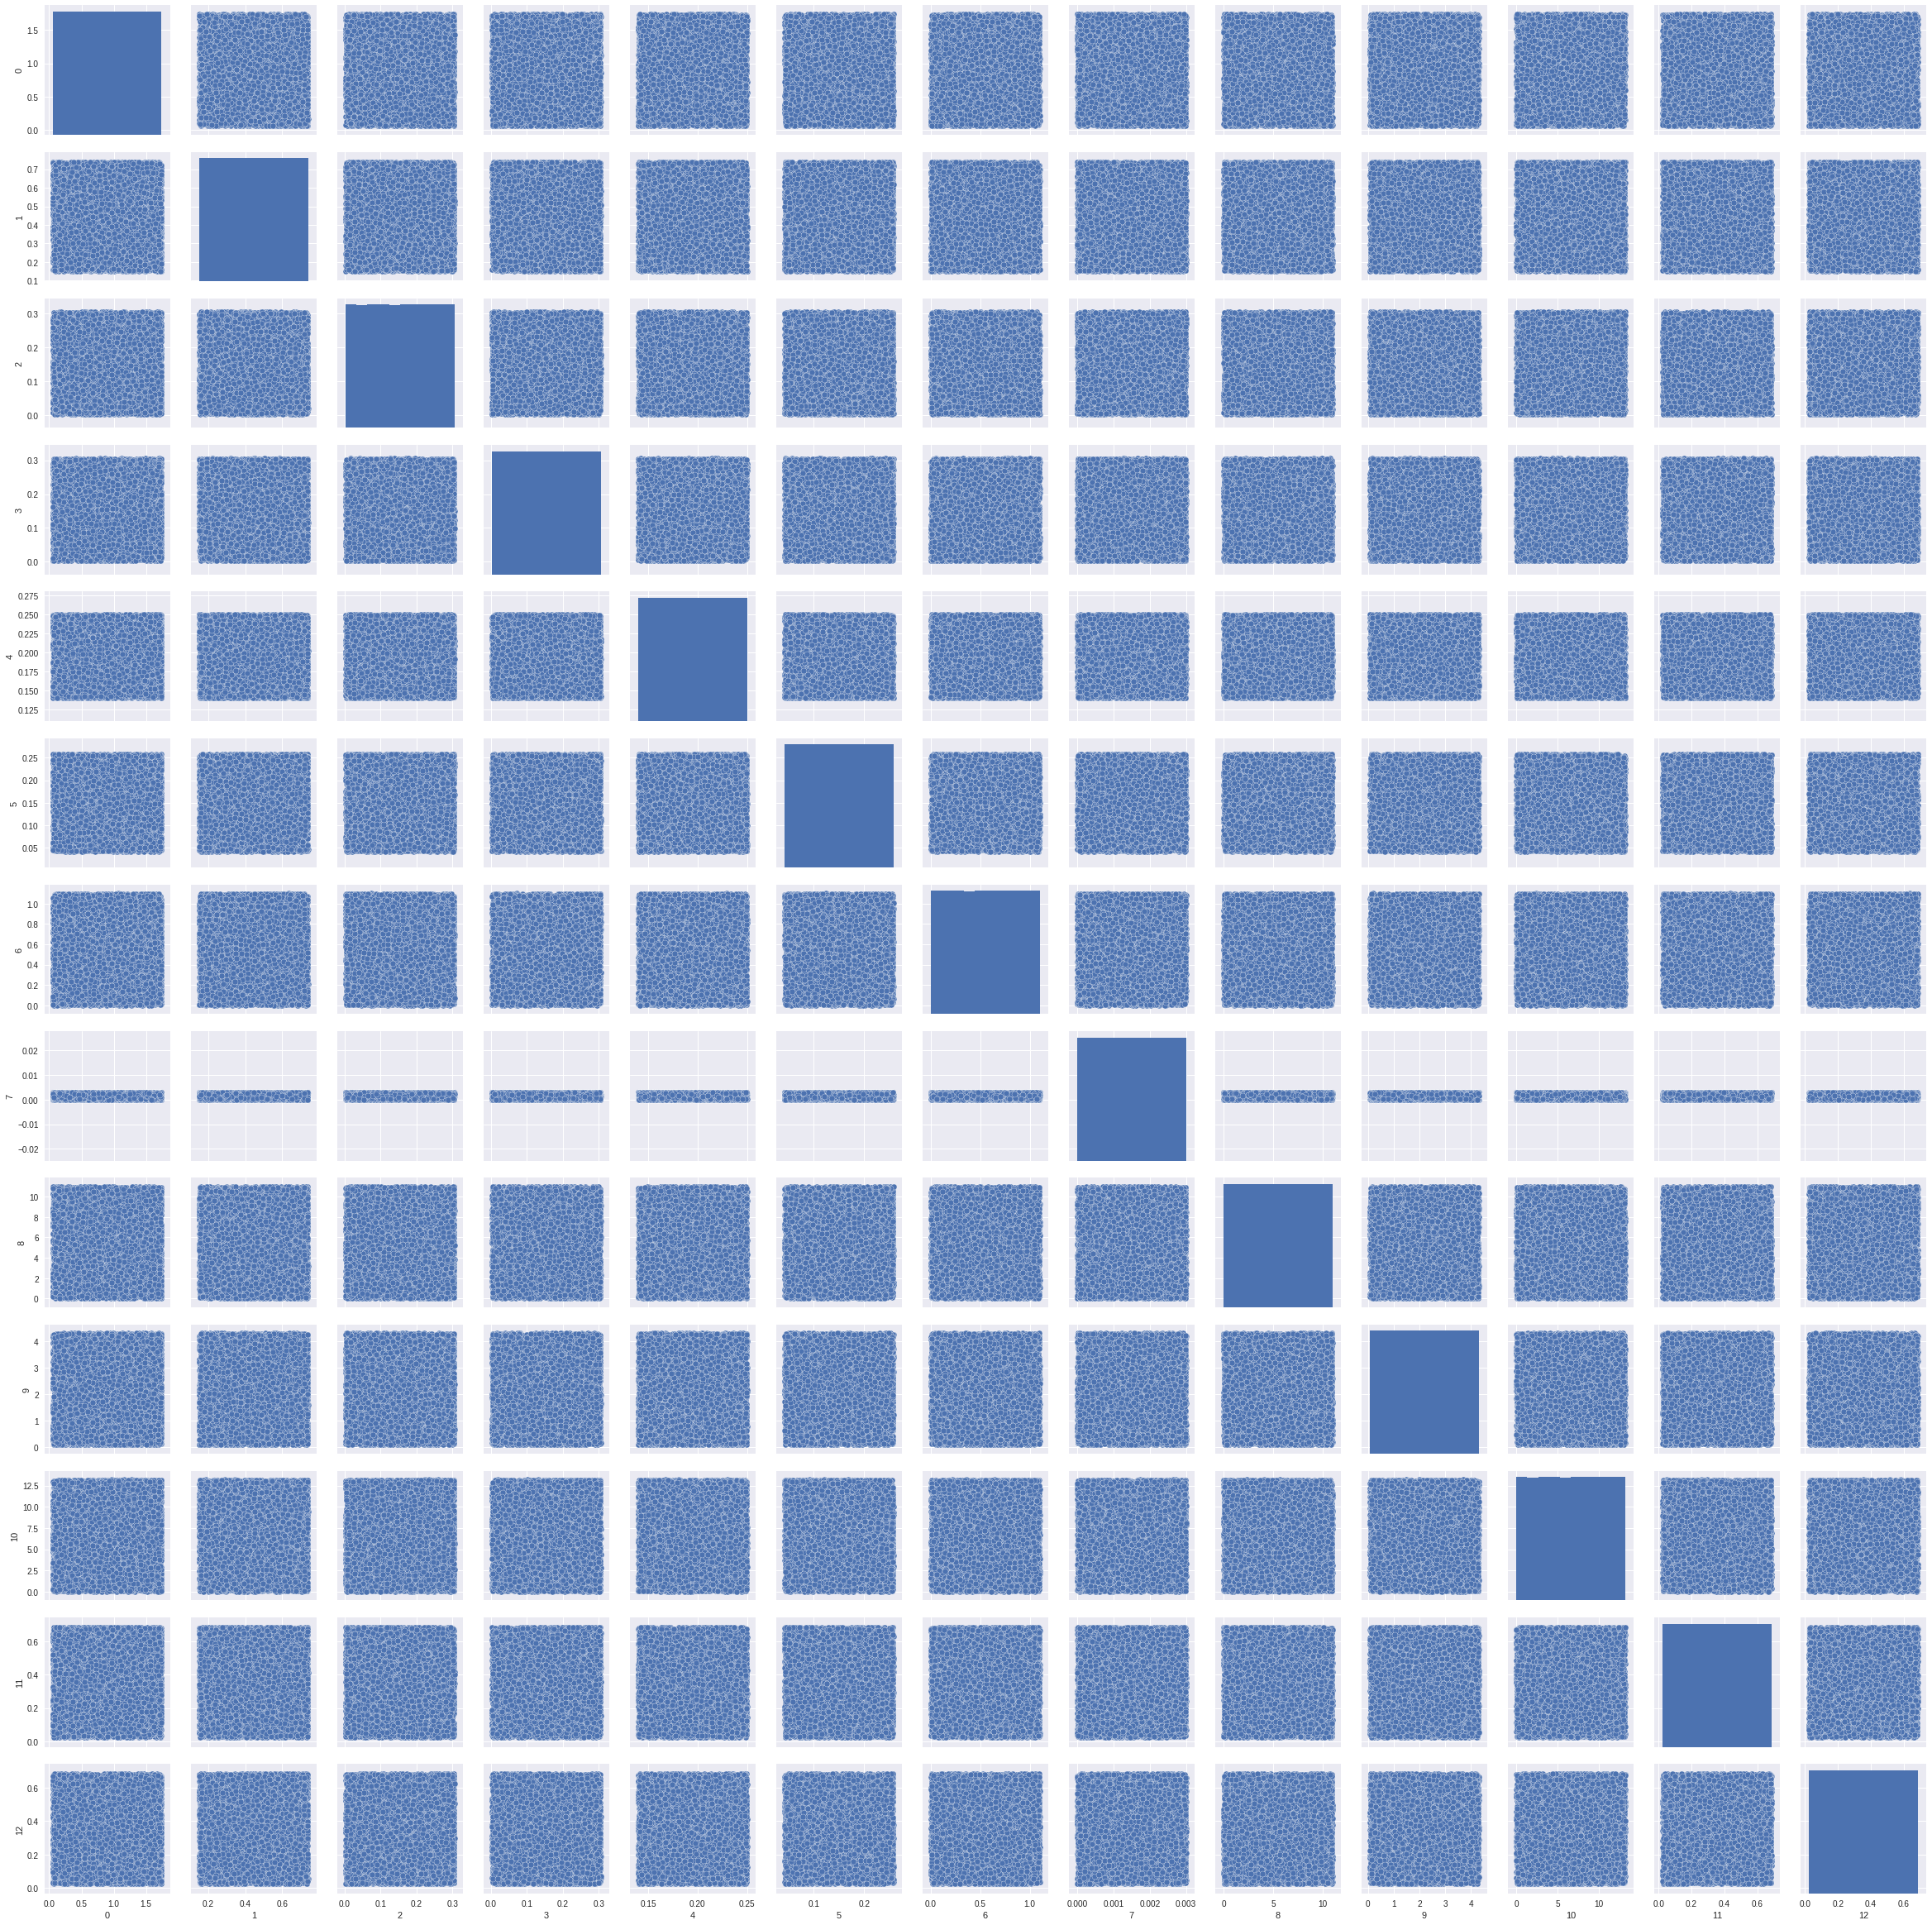

In [211]:
sns.pairplot(pd.DataFrame(param_values))

# py2west section

<font size=3> <b> use this for running a simulation on the eraser and then analize the results in the next sections

In [212]:
from __future__ import print_function, division # Python 3 printing and division

import pandas as pd
import numpy as np
import seaborn as sns
import os, shutil, glob
import py2WEST

from sklearn.utils.extmath import cartesian
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as plticker
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.cm as cm
import matplotlib.mlab as mlab
from matplotlib.mlab import griddata
%matplotlib inline

In [213]:
import ipyparallel as ipp
c = ipp.Client()

In [214]:
%%px --local
import subprocess                           # Run commands in bash
import signal                               # Needed to limit calculation time per simulation 
import shutil
import xml.etree.ElementTree as etxml
import lxml
import os
import py2WEST                              # imported as py2WEST; parse_xml file is saved in py2WEST folder as a package 
import dill
import pickle
from ipykernel import serialize
serialize.pickle = pickle

In [215]:
dview = c[:]                                    # Make directView of all clients, used to parse data/objects to cores
lview = c.load_balanced_view()             # Make balancedView of all clients, used for dynamic calculations

In [216]:
pywest_dir = './'
case_dir = '/home/data/gbelland/gitRepos/EHV_GSA/WEST16_DRYW_N2O/'
save_dir = '/home/data/gbelland/gitRepos/EHV_GSA/WEST16_DRYW_N2O/'

In [218]:
case_name = 'Eindhoven'
experiment_type = r"steady state"#r"dynamic"#
timeout_duration = 10000 #s
default_output = None

<font size=3> <b> N.B.: for global parameters insert the parameter name without point before it

In [223]:
parasets = pd.DataFrame(param_values, columns=columns)

In [224]:
scenario = []
for row in parasets.index:
    scenario.append([row, py2WEST.parse_xml.dframe_to_dict(parasets, row)])
scenario_len = len(scenario)
scenario

[[0,
  {'K_FA_AOBden': 0.16885569475354995,
   'K_FNA_AOBden': 0.0024676430650194389,
   'K_IO_AOBden': 4.8055739420078023,
   'K_O_A1Lysis': 1.1162443247902709,
   'K_O_A2Lysis': 0.61498365439780622,
   'K_SNO_AOBden': 0.2367091204684813,
   'K_SO_AOBden': 0.31686241662804993,
   'Y_A1': 0.23823766880826058,
   'Y_A2': 0.14715020620254457,
   'b_A1': 0.1712663076568656,
   'b_A2': 0.2517145361745855,
   'n1_AOB': 0.37219895905837252,
   'n2_AOB': 0.20565685953038473}],
 [1,
  {'K_FA_AOBden': 0.56467845010980844,
   'K_FNA_AOBden': 0.0016592096668745376,
   'K_IO_AOBden': 10.287178340839956,
   'K_O_A1Lysis': 0.35992437610928441,
   'K_O_A2Lysis': 0.57095175722470815,
   'K_SNO_AOBden': 3.7050387838037548,
   'K_SO_AOBden': 1.7802080230412769,
   'Y_A1': 0.19069738999721733,
   'Y_A2': 0.12922698870086544,
   'b_A1': 0.14265871086932616,
   'b_A2': 0.13942886353205519,
   'n1_AOB': 0.56195270082121351,
   'n2_AOB': 0.36629414776401537}],
 [2,
  {'K_FA_AOBden': 0.50157004511204939,
   '

In [227]:
out = lview.map_async(run_GSA, scenario, [case_dir]*scenario_len, [case_name]*scenario_len, [save_dir]*scenario_len,
                      [experiment_type]*scenario_len, [timeout_duration]*scenario_len)
#while out.progress != scenario_len:
#    continue
print('Done!')

Done!


In [337]:
out.progress

10000

In [339]:
#Lijst [scenario_id, success (1) or no succes (0)]
success = [row[1] for row in out.result()]
failed_scenarios = [i for i,x in enumerate(success) if x == 0]
print(failed_scenarios)
if len(failed_scenarios) != 0:
    print("Total of:", len(failed_scenarios))

[27, 28, 37, 152, 187, 196, 208, 281, 296, 307, 346, 351, 372, 452, 482, 483, 484, 522, 525, 530, 541, 619, 622, 666, 676, 722, 731, 757, 837, 877, 890, 931, 1006, 1030, 1041, 1075, 1126, 1127, 1159, 1226, 1241, 1304, 1320, 1346, 1363, 1376, 1405, 1425, 1448, 1475, 1476, 1500, 1518, 1521, 1578, 1586, 1629, 1739, 1786, 1802, 1830, 1851, 1896, 1905, 1918, 1927, 1942, 1951, 1959, 1967, 2009, 2011, 2070, 2078, 2084, 2106, 2145, 2158, 2188, 2194, 2201, 2212, 2240, 2279, 2343, 2350, 2356, 2368, 2416, 2446, 2478, 2503, 2519, 2562, 2599, 2612, 2659, 2665, 2736, 2768, 2831, 2853, 2909, 2911, 2959, 3001, 3010, 3047, 3060, 3066, 3086, 3108, 3112, 3115, 3145, 3146, 3147, 3157, 3165, 3172, 3182, 3188, 3218, 3234, 3235, 3256, 3258, 3281, 3285, 3288, 3308, 3309, 3320, 3377, 3426, 3469, 3478, 3558, 3584, 3607, 3618, 3677, 3715, 3717, 3728, 3746, 3758, 3790, 3808, 3812, 3826, 3910, 3917, 3971, 3982, 4013, 4030, 4057, 4078, 4081, 4102, 4118, 4133, 4171, 4190, 4224, 4247, 4276, 4302, 4325, 4329, 4332, 43

# show results and analysis with pystran

find a more efficient method to load and process these files

In [ ]:
results, units = reshape_files('./results/metricEval/',
                               'Eindhoven', 'Steady State', len(parasets)) # or Dynamic!
for key in units.keys():
    fig, ax = plt.subplots()
    for column in results['#.t'].columns:
        ax.plot(results['#.t'][column],results[key][column],label=column)
        ax.set_title(key,fontsize=14)
        ax.legend(results['#.t'].columns)

## metric evaluation

In [136]:
observed = 2 #reference measure
modelled = results['.Aer_Anox_ZP.C(S_O)'][-100:].values

In [316]:
def calc_metrics(modelled, observed):

    residuals = np.abs(observed - modelled)
    df = pd.DataFrame({'MAE':np.abs(residuals).mean(axis=0), ### MAE (mean absolute error) range: [0, inf] optimum: 0
                      'RMSE':np.sqrt((residuals**2).mean(axis=0)), ### RMSE (root mean sq error)
                      'MSE':(residuals**2).mean(axis=0), ### MSE (mean sq error) range: [0, inf] optimum: 0
                      'MSLE':((np.log(observed) - np.log(modelled))**2).mean(axis=0), ### MSLE (mean sq log error - emphasises low magnitude errors) range: [0, inf] optimum: 0
                      'RRMSE':np.sqrt((residuals**2).mean(axis=0))/np.mean(observed), ### RRMSE (relative root mean sq error)
                      'SSE':sum(residuals**2), ### SSE (sum of sq errors) range: [0, inf] optimum: 0
                      'AMRE':np.abs((residuals/observed).mean(axis=0)), ### AMRE (abs mean relative error [from MREin pystran]) range: [-inf, inf] optimum: 0
                      'MARE':(np.abs(residuals)/observed).mean(axis=0), ### MARE (mean abs relative error) range: [0, inf] optimum: 0
                      'SARE':(np.abs(residuals)/observed).sum(axis=0), ### SARE (sum of abs relative error) range: [0, inf] optimum: 0
                      'MeAPE':np.median((np.abs(residuals)*100./observed), axis=0), ### MeAPE (median of absolute prediction error) range: [0, inf] optimum: 0
                      'MSRE':((residuals/observed)**2).mean(axis=0), ### MSRE (mean sq relative error) range: [0, inf] optimum: 0
                      'RVE':np.sum(residuals, axis=0)/np.sum(observed, axis=0)} ### RVE (relative vol error) range: [-inf, inf] optimum: 0
                     )
    return df

In [322]:
df = calc_metrics(results['.Aer_Anox_ZP.C(S_O)'][-100:].values,observed)
df.head()

AMRE       MAE      MARE       MSE      MSLE      MSRE     MeAPE  \
0  0.134009  0.268019  0.134009  0.071834  0.020702  0.017959  13.40125   
1  0.231654  0.463309  0.231654  0.214655  0.069441  0.053664  23.16550   
2  0.356976  0.713952  0.356976  0.509728  0.194987  0.127432  35.69775   
3  0.372096  0.744192  0.372096  0.553822  0.216568  0.138455  37.20975   
4  0.317304  0.634608  0.317304  0.402728  0.145699  0.100682  31.73050   

       RMSE     RRMSE        RVE       SARE        SSE  
0  0.268019  0.134010  13.400945  13.400945   7.183421  
1  0.463309  0.231654  23.165440  23.165440  21.465515  
2  0.713952  0.356976  35.697605  35.697605  50.972778  
3  0.744192  0.372096  37.209590  37.209590  55.382181  
4  0.634608  0.317304  31.730415  31.730415  40.272781

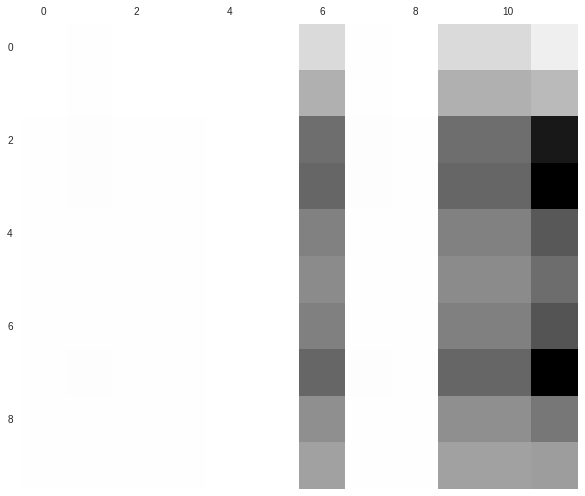

In [251]:
fig, ax1 = plt.subplots(figsize=(10, 10))
ax1.matshow(df, interpolation=None)
ax1.grid(False)

<font size=4 color='green'> NB: non scaled metrics do not clearly appear to have a common trend, but the scaled version does

### Scaled scores

In [229]:
from sklearn import preprocessing

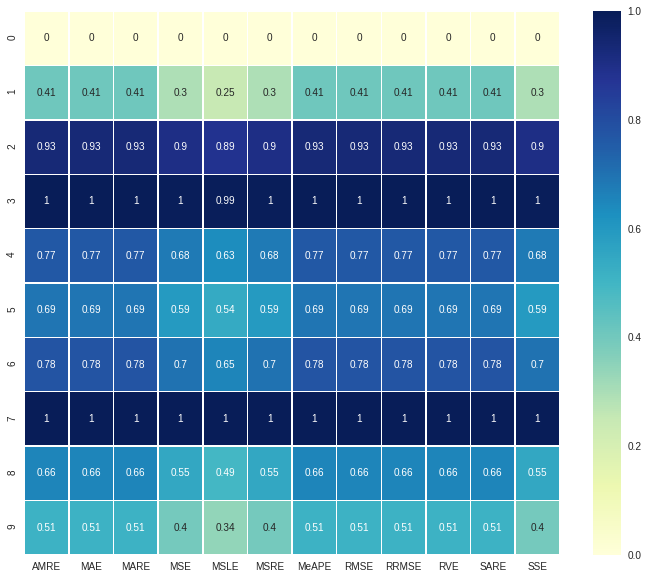

In [314]:
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(df)

fig, ax1 = plt.subplots(figsize=(12, 10))
sns.heatmap(x_scaled, ax=ax1, annot=True, linewidths=.5, cmap="YlGnBu")

# ax1.xaxis.set_major_locator(plt.MaxNLocator(nbins=13))
ax1.set_xticklabels(df.columns.tolist()); # there is a bug in the set_ticklabels and the first label gets lost

# # fig.patch.set_visible(True)
# ax1.grid(False)

TO DO: add more metrics and 